In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T174300Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9bafa8e86dbef8876264af02658b5e278777364a262a29a1cd18576892a1571440cd58ee9cc4cc08773e401bcaa5e29af81e3eb70924c992bab03b2d9041f8a50334c22f1186ba57d08eb2440486d196be45350af24c5ca9a884d8b7de006be22c1037c111dc3b3016cf256b95e57cf6ede76135101e23c62abfda604277a0941aaf8fd2b17976aa6f73bc0f7fcda2834d30c0305a4e036966c2ee7712a7e6de9f7dc85fc4415914c4f5a4e5bfa03c3fe77113cdddd7a3d602e1b30fb8818ac44248b97d7a61d64b41bc53eeaa6a6ceee48a09c775d7b2bef52d0ef2c0ae55f16d691f9203daf6fd912bb4bf8ecfc33865d8be2e3404e2bb803f5ac1c26aa414'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection  import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [3]:
data= pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df=data
data.isnull().sum().sum()


0

In [6]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

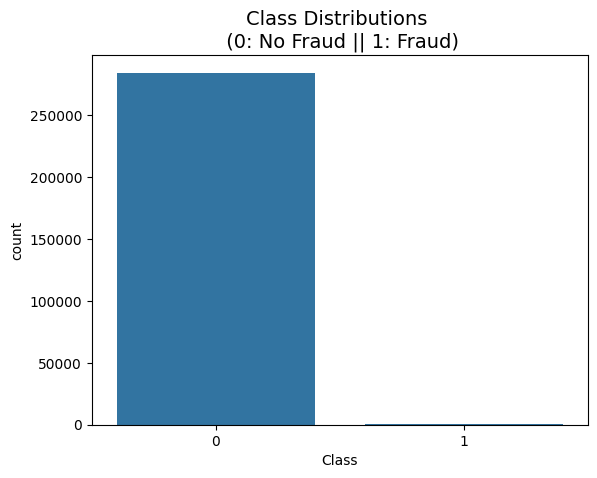

In [7]:
sns.countplot(x='Class',data = data)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [8]:
tmp = df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']

In [9]:
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
# The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

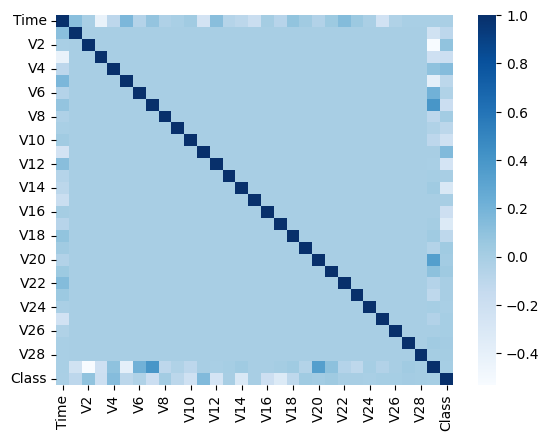

In [12]:
dataplot = sns.heatmap(data.corr(), cmap="Blues")
plt.show()

In [13]:
X = data.drop("Class", axis=1)
y = data['Class']

In [14]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.00000000e+00, 9.35192337e-01, 7.66490419e-01, ...,
        4.18976135e-01, 3.12696634e-01, 5.82379309e-03],
       [0.00000000e+00, 9.78541955e-01, 7.70066651e-01, ...,
        4.16345145e-01, 3.13422663e-01, 1.04705276e-04],
       [5.78730497e-06, 9.35217023e-01, 7.53117667e-01, ...,
        4.15489266e-01, 3.11911316e-01, 1.47389219e-02],
       ...,
       [9.99976851e-01, 9.90904812e-01, 7.64079694e-01, ...,
        4.16593177e-01, 3.12584864e-01, 2.64215395e-03],
       [9.99976851e-01, 9.54208999e-01, 7.72855742e-01, ...,
        4.18519535e-01, 3.15245157e-01, 3.89238944e-04],
       [1.00000000e+00, 9.49231759e-01, 7.65256401e-01, ...,
        4.16466371e-01, 3.13400843e-01, 8.44648509e-03]])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)

In [16]:
y_train.value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [17]:
smote = SMOTE(random_state=0)

X_train, y_train = smote.fit_resample(X_train,y_train)
X_test, y_test = smote.fit_resample(X_test,y_test)

In [18]:
y_train.value_counts()

Class
0    227451
1    227451
Name: count, dtype: int64

# Model

In [19]:
def evaluate(model):
  model.fit(X_train,y_train)
  pre = model.predict(X_test)

  accuracy = accuracy_score(pre,y_test)
  recall = recall_score(pre,y_test)
  f1 = f1_score(pre,y_test)

  sns.heatmap(confusion_matrix(pre,y_test),annot=True)
  print(model)
  print('Accuracy : ',accuracy,'Recall : ',recall,"F1 : ",f1)

In [20]:
model_LR = LogisticRegression()

In [21]:
#perform cross validation

grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}  # l2 ridge

clf_lsr_cv = GridSearchCV(model_LR,grid,cv=3,scoring='roc_auc')
clf_lsr_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_lsr_cv.best_params_)
print("accuracy :",clf_lsr_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
accuracy : 0.9911487012978606


LogisticRegression(C=1000.0, random_state=42)
Accuracy :  0.9450267304445695 Recall :  0.9713354442168002 F1 :  0.9434484505309623


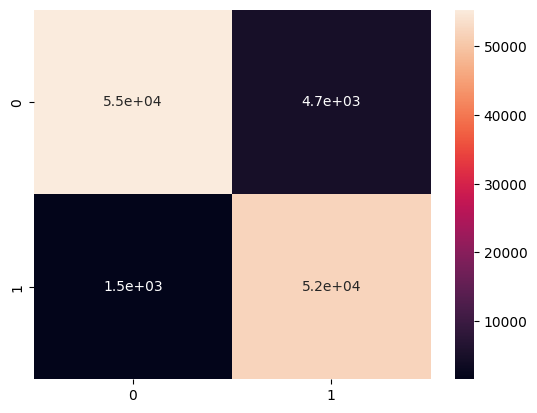

In [22]:
# Fitting the model with best parameters .

lsr_best = LogisticRegression(penalty='l2',C=1000.0,random_state = 42)
lsr_clf = lsr_best.fit(X_train,y_train)
evaluate(lsr_clf)

In [23]:
model_KNN = KNeighborsClassifier()

In [ ]:
import time

k_range = np.arange(1, 20, 2)
scores = []  # To store cross-validation score for each k

start_time = time.time()  # Start timer

for k in k_range:
    model_KNN = KNeighborsClassifier(n_neighbors=k)
    model_KNN.fit(X_train, y_train)
    score = cross_val_score(model_KNN, X_train, y_train, cv=2, n_jobs=-1)
    scores.append(score.mean())

end_time = time.time()  # End timer

# Storing the mean squared error to decide optimum k
mse = [1 - x for x in scores]

total_time = end_time - start_time
print(f"Execution time (KNN cross-validation): {total_time:.2f} seconds")


In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sns.lineplot(x=k_range,y=mse,markers=True,dashes=False)
plt.xlabel("Value of K")
plt.ylabel("Mean Squared Error")
plt.subplot(122)
sns.lineplot(x=k_range,y=scores,markers=True,dashes=False)
plt.xlabel("Value of K")
plt.ylabel("Cross Validation Accuracy")

plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

knn_clf = knn.fit(X_train,y_train)

evaluate(knn_clf)

In [ ]:
model_RFC = RandomForestClassifier()

In [ ]:
# Using grid search cv to find the best parameters.

param = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [2, 3, 4, 7, 9]}
clf_rfc_cv = GridSearchCV(model_RFC, param, cv=5,scoring='roc_auc', n_jobs=-1)
clf_rfc_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_rfc_cv.best_params_)
print("accuracy :",clf_rfc_cv.best_score_)


In [ ]:
#Fitting model

rf = RandomForestClassifier(max_depth=9, n_estimators=50)
RFC_clf = rf.fit(X_train,y_train)

evaluate(RFC_clf)

In [ ]:
model_ANN = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),

    Dense(16, activation='relu'),

    Dense(8, activation='relu'),
.3
    Dense(1, activation='sigmoid')
])

model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ANN.summary()

In [ ]:
history = model_ANN.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

In [ ]:
y_pred = model_ANN.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
classification_report(y_pred,y_test)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
X

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1],
            s = 100, c = 'red', label = 'non-Fraud')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1],
            s = 100, c = 'blue', label = 'Fraud')

# Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1],
            s = 100, c = 'yellow', label = 'Centroids')

plt.legend()